In [1]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
actions = [
    'graduate',
    'mis_graduate',
    'practice',
    'mis_practice1',
    'mis_practice2',
    'write'
]

data = np.concatenate([
    np.load('dataset_edu/seq_graduate_1680243462.npy'),
    np.load('dataset_edu/seq_mis_graduate_1680243462.npy'),
    np.load('dataset_edu/seq_practice_1680243462.npy'),
    np.load('dataset_edu/seq_mis_practice1_1680243462.npy'),
    np.load('dataset_edu/seq_mis_practice2_1680243462.npy'),
    np.load('dataset_edu/seq_write_1680243462.npy')
], axis=0)

data.shape

(7929, 30, 100)

In [3]:
x_data = data[:,:, :-1] #라벨 값만 빼고 x_data로 만듦
labels = data[:,0,-1] #마지막 값이 라벨이므로 마지막 값만 라벨로 만듬

print(x_data.shape)
print(labels.shape)

(7929, 30, 99)
(7929,)


In [4]:
from keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(7929, 6)

In [5]:
from sklearn.model_selection import train_test_split
# training set과 testset을 나눔

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(7136, 30, 99) (7136, 6)
(793, 30, 99) (793, 6)


In [6]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                41984     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 6)                 198       
                                                                 
Total params: 44,262
Trainable params: 44,262
Non-trainable params: 0
_________________________________________________________________


In [7]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200
220/223 [============================>.] - ETA: 0s - loss: 48.3745 - acc: 0.2420
Epoch 1: val_acc improved from -inf to 0.34552, saving model to models\model.h5
223/223 [==============================] - 5s 15ms/step - loss: 47.9473 - acc: 0.2431 - val_loss: 17.1712 - val_acc: 0.3455 - lr: 0.0010
Epoch 2/200
220/223 [============================>.] - ETA: 0s - loss: 7.9883 - acc: 0.4392
Epoch 2: val_acc improved from 0.34552 to 0.54098, saving model to models\model.h5
223/223 [==============================] - 3s 14ms/step - loss: 7.9266 - acc: 0.4414 - val_loss: 4.4493 - val_acc: 0.5410 - lr: 0.0010
Epoch 3/200
222/223 [============================>.] - ETA: 0s - loss: 3.8391 - acc: 0.5546
Epoch 3: val_acc improved from 0.54098 to 0.61665, saving model to models\model.h5
223/223 [==============================] - 3s 13ms/step - loss: 3.8329 - acc: 0.5548 - val_loss: 3.7143 - val_acc: 0.6166 - lr: 0.0010
Epoch 4/200
221/223 [============================>.] - ETA: 0s - loss:

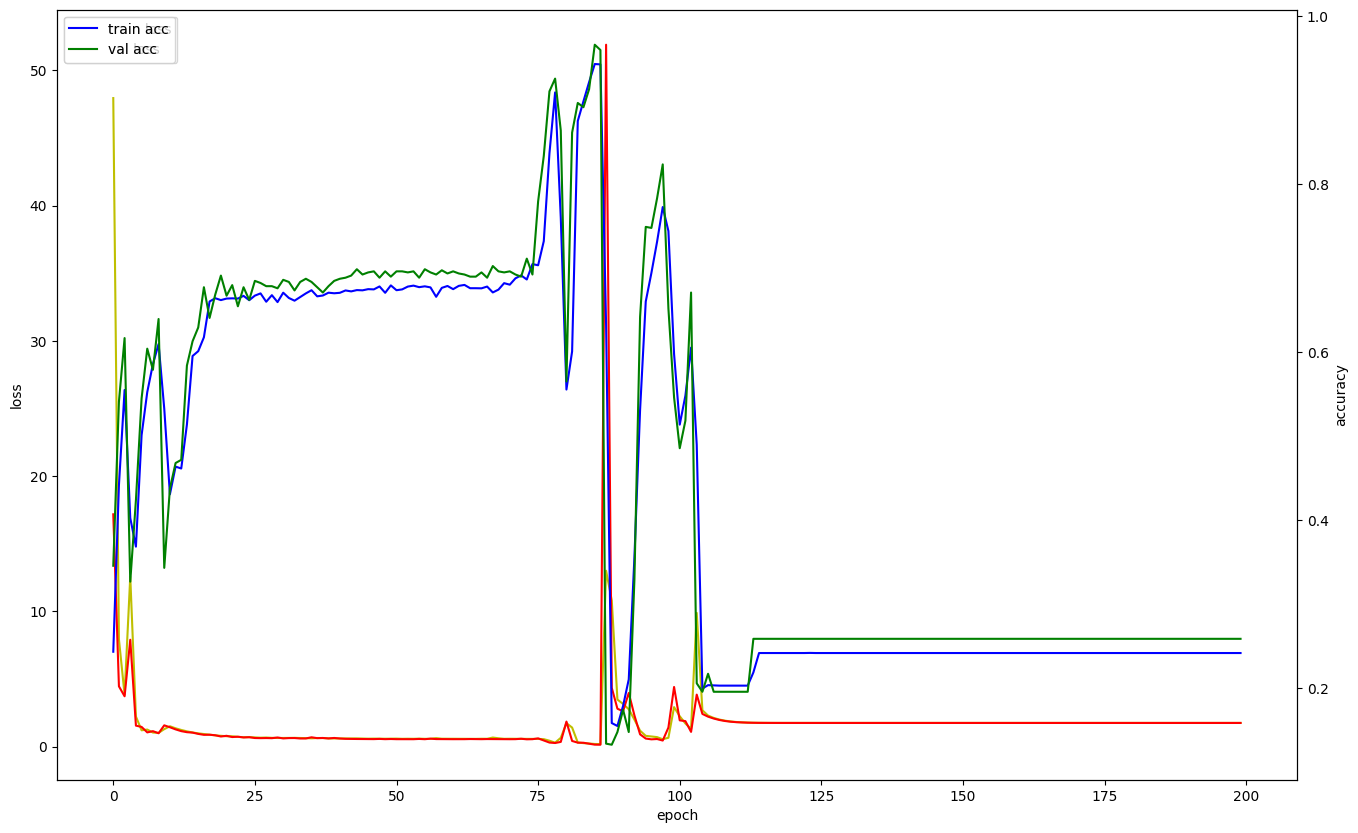

In [8]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [9]:
from sklearn.metrics import multilabel_confusion_matrix
from keras.models import load_model

model = load_model('models/model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

25/25 [==============================] - 0s 6ms/step


array([[[634,   3],
        [  1, 155]],

       [[628,  10],
        [ 17, 138]],

       [[684,   0],
        [  0, 109]],

       [[692,  14],
        [  9,  78]],

       [[712,   0],
        [  0,  81]],

       [[588,   0],
        [  0, 205]]], dtype=int64)